In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
raw_data = pd.read_csv("../../01.files/02.Bigsata_analysis/환율.csv", parse_dates=['APPL_DATE'])
raw_data

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294
...,...,...,...,...
268,JPY,2016-03-30,1026.90,0.8906
269,USD,2016-03-30,1153.00,1.0000
270,CNY,2016-03-31,176.96,0.1547
271,JPY,2016-03-31,1017.57,0.8895


In [28]:
df_USD = raw_data[raw_data["CURRENCY"] == "USD"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)
df_USD

,STD_RATE
APPL_DATE,
2016-01-01,1178.0
2016-01-02,1178.0
2016-01-03,1178.0
2016-01-04,1184.0
2016-01-05,1185.0
...,...
2016-03-27,1169.0
2016-03-28,1169.0
2016-03-29,1162.0


Text(0, 0.5, 'STD_RATE')

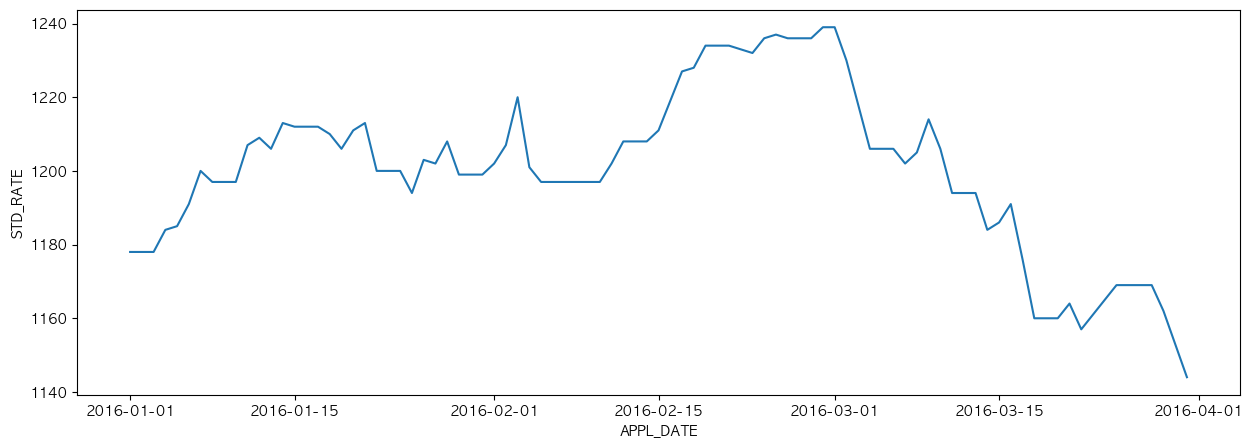

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(df_USD.index, df_USD["STD_RATE"])
plt.xlabel("APPL_DATE")
plt.ylabel("STD_RATE")

그래프로 보았을 때는 데이터에 계절성이나, 주기성이 보이지 않음

In [30]:
# 데이터 분할

train_size = 0.8
len_idx = len(df_USD.index)

mask = (np.arange(len_idx) / len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [31]:
df_USD_train = df_USD[mask]
df_USD_test = df_USD[~mask]
print("shape of train data: {}".format(df_USD_train.shape))
print("shape of test data: {}".format(df_USD_test.shape))

shape of train data: (73, 1)
shape of test data: (18, 1)


In [32]:
df_USD_train

,STD_RATE
APPL_DATE,
2016-01-01,1178.0
2016-01-02,1178.0
2016-01-03,1178.0
2016-01-04,1184.0
2016-01-05,1185.0
...,...
2016-03-09,1214.0
2016-03-10,1206.0
2016-03-11,1194.0


### 차분(d)
1. 1차 차분 후 고르게 분포되지않고 0 이상의 추세가 많음을 보임
2. 2차 차분 후 추세나 경향성이 거의 제거되어 추세를 읽을 수 없는 상태가 됨.
   -> 따라서 d의 값은 2로 결정

<Axes: xlabel='APPL_DATE'>

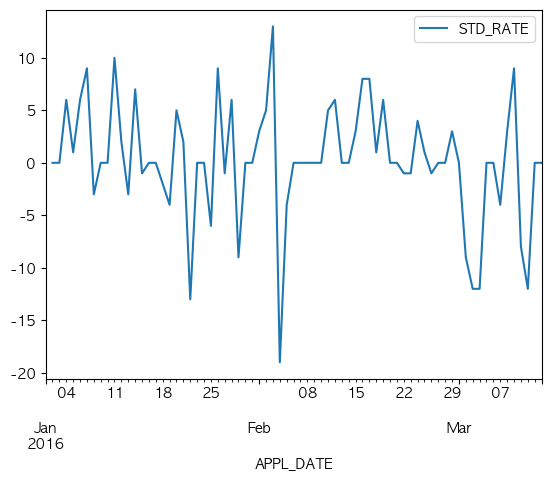

In [33]:
df_USD_diff1 = df_USD_train - df_USD_train.shift(1)
df_USD_diff1.plot()

<Axes: xlabel='APPL_DATE'>

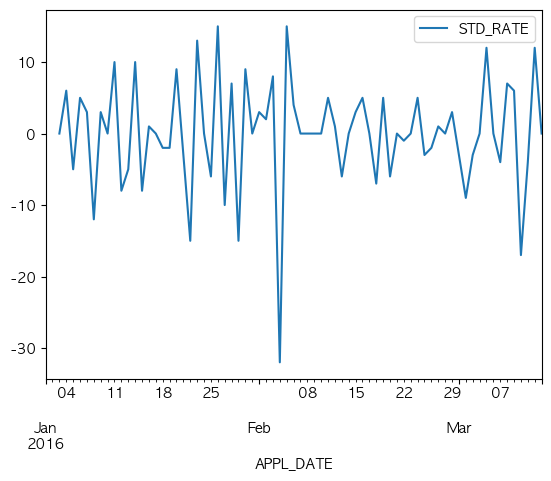

In [35]:
df_USD_diff2 = df_USD_train - 2 * (df_USD_train.shift(1)) + (df_USD_train.shift(2))
df_USD_diff2.plot()

### 자기회귀 (p, q)
1. Pacf 그래프에서 두번째가 절단면이며, 그 이후로 급격하게 감소하는 형태를 보이므로 p = 1을 선택
2. Acf 그래프에서는 지수적으로 감소하고 올라가는 형태를 보이기 때문에 q = 0을 선택함

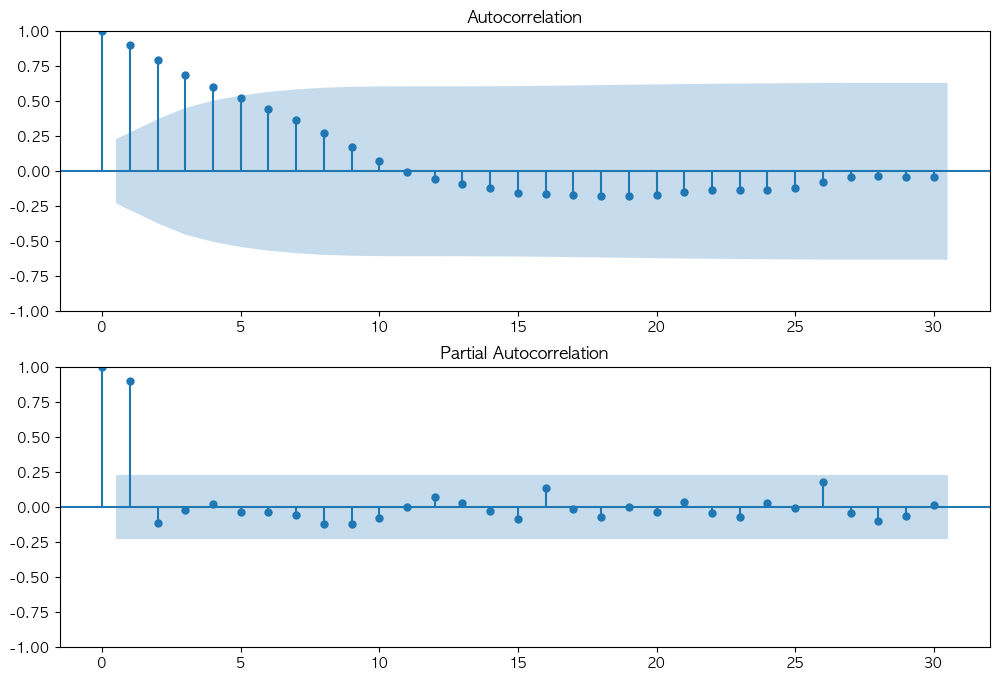

In [36]:
lag_size = 30
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_USD_train["STD_RATE"], lags = lag_size, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_USD_train["STD_RATE"], lags = lag_size, ax = ax2)

### 모델 예측 결과

위에서 정한 파라미터를 기준으로 선택하였을 때, AIC 481, BIC 486의 값을 가진다.          
그러나 아래 예측 그래프를 보았을 때, 마지막 값을 계속 유지하는 형태를 보이며, 추세를 따르거나 예측하는 모습을 보이지 않고 있다.
이는 각 데이터가 과거 오차와 독립적이지 못하고, 과거의 데이터를 바탕으로 예측을 진행해야 한다는 것으로 분석된다.

In [76]:
arima_model = ARIMA(df_USD_train, order = (1, 2, 0)) # p, d, q

arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   73
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -238.745
Date:                Wed, 19 Mar 2025   AIC                            481.490
Time:                        16:44:50   BIC                            486.016
Sample:                    01-01-2016   HQIC                           483.290
                         - 03-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4156      0.124     -3.359      0.001      -0.658      -0.173
sigma2        48.6504      5.889      8.261      0.000      37.108      60.193
Ljung-Box (L1) (Q):                   1.85   Jarque-

<Axes: >

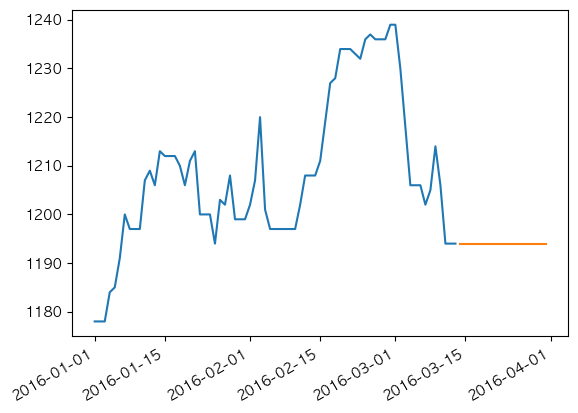

In [77]:
start_time = df_USD_test.index.min()
end_time = df_USD_test.index.max()
plt.plot(df_USD_train)
arima_result.predict(start=start_time, end=end_time, plot_insample=False).plot()

In [78]:
start_time = pd.to_datetime("2016-01-03")
y_pred = arima_result.predict(start=start_time, end=end_time, typ= 'levels')

df_merge = df_USD
df_merge["예측값"]=y_pred 
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,1178.0,NaN
2016-01-02,1178.0,NaN
2016-01-03,1178.0,1178.028789
2016-01-04,1184.0,1178.000000
2016-01-05,1185.0,1187.506376


<Axes: xlabel='APPL_DATE'>

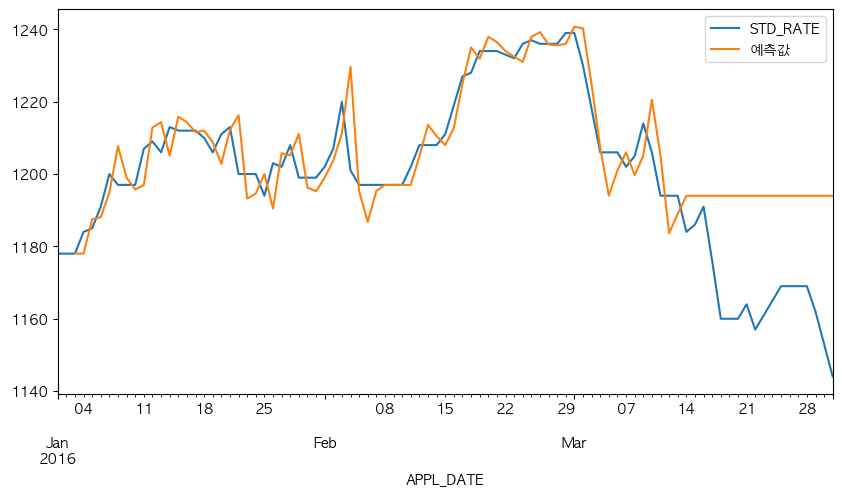

In [79]:
df_merge.plot( y=["STD_RATE","예측값"], figsize=(10,5))

### auto_arima를 사용한 최적 값 찾기

위에서 제대로 예측하지 못했기 때문에, auto arima를 사용하여 최적의 값을 찾고자 하였다.      
베스트 모델의 결과로 나온 (0,2,1)을 선택하여 다시 학습하였을 때        
잘 예측하지는 못하지만 추세를 따라가는 것은 볼 수 있다. 

In [84]:
a_arima = auto_arima(df_USD_train, max_p=5, max_q=5, d=2, 
                      trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=461.226, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=493.181, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=481.490, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=456.103, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=457.774, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=457.702, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=459.463, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.420 seconds


In [85]:
arima_model_final = ARIMA(df_USD_train, order = (0, 2, 1))
arima_result_final = arima_model_final.fit()
print(arima_result_final.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   73
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -226.051
Date:                Wed, 19 Mar 2025   AIC                            456.103
Time:                        16:52:06   BIC                            460.628
Sample:                    01-01-2016   HQIC                           457.902
                         - 03-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9359      0.063    -14.803      0.000      -1.060      -0.812
sigma2        33.1277      4.117      8.047      0.000      25.059      41.197
Ljung-Box (L1) (Q):                   0.10   Jarque-

<Axes: >

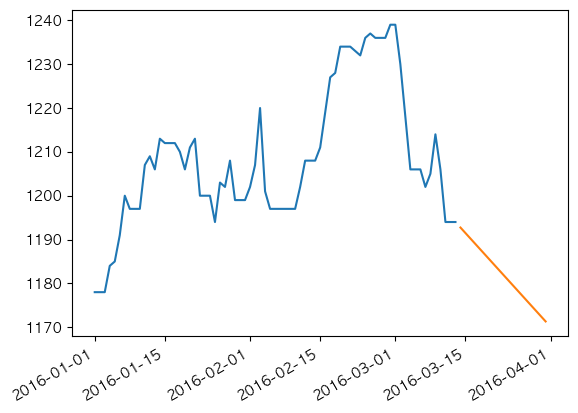

In [87]:
start_time = df_USD_test.index.min()
end_time = df_USD_test.index.max()
plt.plot(df_USD_train)
arima_result_final.predict(start=start_time, end=end_time, plot_insample=False).plot()

In [88]:
start_time = pd.to_datetime("2016-01-03")
y_pred = arima_result_final.predict(start=start_time, end=end_time, typ= 'levels')

df_merge = df_USD
df_merge["예측값"]=y_pred 
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,1178.0,NaN
2016-01-02,1178.0,NaN
2016-01-03,1178.0,1178.036520
2016-01-04,1184.0,1178.018221
2016-01-05,1185.0,1186.026630


<Axes: xlabel='APPL_DATE'>

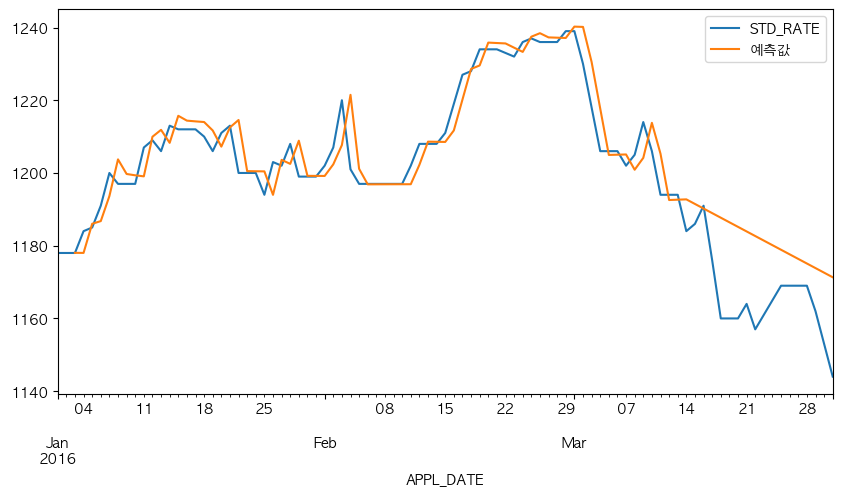

In [89]:
df_merge.plot( y=["STD_RATE","예측값"], figsize=(10, 5))